# Exercise 5.12: Racetrack from the Reinforcement Learning textbook

- toc: true 
- badges: true
- comments: true
- categories: [ja]

Here I demonstrate the execise 5.12 of the textbook [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Richard Sutton and Andrew G. Barto, using both of planning method and Monte Carlo method.
Basic knowledge of Python (>= 3.7) and [NumPy](https://numpy.org/) are assumed.
Some konwledge of [matplotlib](https://matplotlib.org/) and [Python typing library](https://docs.python.org/3/library/typing.html) also helps.

Contact: `yuji.kanagawa@oist.jp`

## Modeling the problem in code

Let's start from writing the problem in code.
What are important in this phase?
Here, I'd like to emphasize the importantness of looking back at the definition of the environment.
I.e., in reinforcement learning (RL), environments are modelled by Markov decision process (MDP), consisting of **states, actions, transition function, and reward function**.
So first let's check the definition of **states** and **actions** in the problem statement.
It's (somehow) not very straightforward, but we can find
> In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step.

So, a state consists of **position** and **velocity** of the car (a.k.a. agent).
What about actions?

> The actions are increments to the velocity components. Each may be changed by +1, −1, or 0 in each step, for a total of nine ($3 \times 3$) actions.

So there are 9 actions for each direction (↓↙←↖↑↗→↘ or no acceleration).
Here, we can also notice that the total number of states is given by $\textrm{Num. positions} \times \textrm{Num. choices of velocity}$.
And the texbook also says
> Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line.

So there are 24 possible velocity at the non-starting positions:

In [1]:
import itertools
list(itertools.product(range(5), range(5)))[1:]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

Again, number of states is given by (roughly) $24 \times \textrm{Num. positions}$ and number of actions is $9$.
Sounds not very easy problem with many positions.

So, let's start the coding from representing the state and actions.
There are multiple ways, but I prefer to NumPy array for representing everything.

Let's consider a ASCII representation of the map (or track) like this:

In [106]:
SMALL_TRACK = """
######   F
###      F
##      ##
#      ###
#SSSSS####
"""

Here, `S` denotes a starting positiona, `F` denotes a finishing position, `#` denotes a wall, and ` ` denotes a road.
We have this track as a 2D NumPy Array, and encode agent's position as an index of this array.

In [107]:
import numpy as np

def ascii_to_array(ascii_track: str) -> np.ndarray:
    lines = [line for line in ascii_track.split("\n") if len(line) > 0]
    byte_lines = [list(bytes(line, encoding="utf-8")) for line in lines]
    return np.array(byte_lines, dtype=np.uint8)

track = ascii_to_array(SMALL_TRACK)
print(track)
position = np.array([0, 0])
track[tuple(position)] == int.from_bytes(b'#', "big")

[[35 35 35 35 35 35 32 32 32 70]
 [35 35 35 32 32 32 32 32 32 70]
 [35 35 32 32 32 32 32 32 35 35]
 [35 32 32 32 32 32 32 35 35 35]
 [35 83 83 83 83 83 35 35 35 35]]


True

Then, agent's velocity and acceleration are also naturally represented by an array.
And, we represent an action as an index of an array consisting of all possible acceleration vetors:

In [108]:
np.array(list(itertools.product([-1, 0, 1], [-1, 0, 1])))

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

The next step is to represent a transition function as a **black box simulator**.
Note that we will visit another representation by **transition matrix**, but implementing the simulator is easier.
Basically, the simulator should take an agent's action and current state, and then return the next state.
Let's call this function `step`.
However, let's make it return some other things to make the implementation easier.
Reward function sounds fairly easy to implement given the agent's position.
> The rewards are −1 for each step until the car crosses the finish line.

Also, we have to handle the *termination* of the episode.
> Each episode begins in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line.

So the resulting `step` function should return a tuple `(state, reward, termination)`.
The below cell contains my implementation of the simulator with matplotlib visualization.

State(position=array([4, 5]), velocity=array([0, 0]))


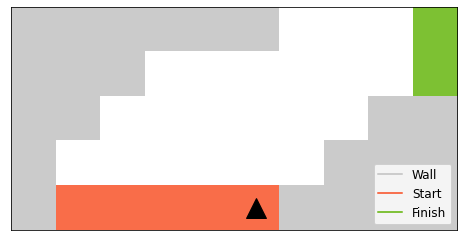

State(position=array([3, 5]), velocity=array([1, 0]))


<AxesSubplot:>

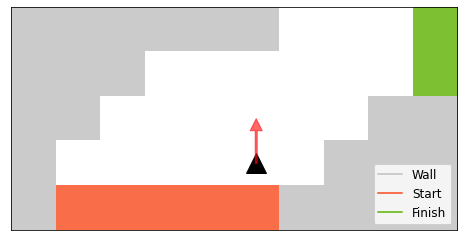

In [124]:
from typing import NamedTuple, Optional, Tuple

from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap


class State(NamedTuple):
    position: np.ndarray
    velocity: np.ndarray


class RacetrackEnv:
    EMPTY = int.from_bytes(b" ", "big")
    WALL = int.from_bytes(b"#", "big")
    START = int.from_bytes(b"S", "big")
    FINISH = int.from_bytes(b"F", "big")

    def __init__(
        self,
        ascii_track: str,
        noise_prob: float = 0.1,
        seed: int = 0,
    ) -> None:
        self._track = ascii_to_array(ascii_track)
        self._max_height, self._max_width = self._track.shape
        self._noise_prob = noise_prob
        self._actions = np.array(list(itertools.product([-1, 0, 1], [-1, 0, 1])))
        self._no_accel = 4
        self._random_state = np.random.RandomState(seed=seed)
        self._start_positions = np.argwhere(self._track == self.START)
        self._ax = None
        self._agent_fig = None

    def step(self, state: State, action: int) -> Tuple[State, float, bool]:
        position, velocity = state
        if self._random_state.rand() < self._noise_prob:
            accel = self._actions[no_accel]
        else:
            accel = self._actions[action]
        # velocity is clipped so that only ↑→ directions are possible
        next_velocity = np.clip(velocity + accel, a_min=0, a_max=4)
        # If both of velocity is 0, cancel the acceleration
        if np.sum(next_velocity) == 0:
            next_velocity = velocity
        # y_velocity is flipped to adjust the coordinate system
        next_position = position + next_velocity * np.array([-1, 1])
        clipped_position = np.clip(
            next_position,
            a_min=0,
            a_max=(self._max_height - 1, self._max_width - 1),
        )
        next_track = self._track[tuple(clipped_position)]
        if next_track == self.FINISH:
            # Goal!
            return State(next_position, next_velocity), 0, True
        elif (
            next_position[0] >= self._max_height
            or next_position[1] >= self._max_width
            or next_track == self.WALL
        ):
            # Out of the track
            return self.reset(), -1.0, False
        else:
            return State(next_position, next_velocity), -1, False

    def reset(self) -> State:
        n_starts = len(self._start_positions)
        initial_pos_idx = self._random_state.choice(n_starts)
        initial_pos = self._start_positions[initial_pos_idx]
        initial_velocity = np.array([0, 0])
        return State(initial_pos, initial_velocity)

    def render(
        self,
        state: Optional[State] = None,
        figsize: Tuple[float, float] = (8.0, 8.0),
    ) -> Axes:
        if self._ax is None:
            figure = plt.figure(figsize=figsize)
            ax = figure.add_subplot(111)
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])
            # Map the track to one of [0, 1, 2, 3] to that simple colormap works
            map_array = np.zeros_like(track)
            symbols = [self.EMPTY, self.WALL, self.START, self.FINISH]
            for i in range(track.shape[0]):
                for j in range(track.shape[1]):
                    map_array[i, j] = symbols.index(self._track[i, j])
            cm = ListedColormap(
                ["w", ".75", "xkcd:reddish orange", "xkcd:kermit green"]
            )
            map_img = ax.imshow(
                map_array,
                cmap=cm,
                vmin=0,
                vmax=4,
                alpha=0.8,
            )
            descriptions = ["Empty", "Wall", "Start", "Finish"]
            for i in range(1, 4):
                if np.any(map_array == i):
                    ax.plot([0.0], [0.0], color=cm(i), label=descriptions[i])
            ax.legend(fontsize=12, loc="lower right")
            self._ax = ax
        if state is not None:
            if self._agent_fig is not None:
                self._agent_fig.remove()
            pos, vel = state
            self._agent_fig = self._ax.plot(pos[1], pos[0], "k^", markersize=20)[0]
            # Show velocity
            self._ax.annotate(
                "",
                xy=(pos[1] + vel[1], pos[0] - vel[0]),
                xycoords="data",
                xytext=(pos[1], pos[0]),
                textcoords="data",
                arrowprops={"color": "red", "alpha": 0.6, "width": 2},
            )
        return self._ax


env = RacetrackEnv(SMALL_TRACK)
state = env.reset()
print(state)
display(env.render(state=state).get_figure())
next_state, reward, termination = env.step(state, 7)
print(next_state)
env.render(state=next_state)

Note that the vertical velocity is negative, so that we can simply represent the coordinate by an array index.

## Solve a small problem by dynamic programming

OK, now we have a simulator, so let's solve the problem!
However, before stepping into reinforcement learning, it's better to compute an optimal policy in a small problem for sanity check.
To do so, we need a transition matrix `p`, which is a $|\mathcal{S}| \times |\mathcal{A}| \times |\mathcal{S}|$ NumPy array where `p[i][j][k]` is the probability of transiting from `i` to `k` when action `j` is taken.
Also, we need a $|\mathcal{S}| \times |\mathcal{A}| \times |\mathcal{S}|$ reward matrix `r`.
Note that this representation is not general as $R_t$ can be stochastic, but since the only stochasticity of rewards is the noise to actions in this problem, this notion suffices.
It is often not very straightforward to get `p` and `r` from the problem definition, but basically we need to give 0-indexd indices to each state (`0, 1, 2, ...`) and fill the array.

In [137]:
def get_p_and_r(env: RacetrackEnv) -> Tuple[np.ndarray, np.ndarray]:
    velocities = list(itertools.product(range(5), range(5)))
    state_indices = np.zeros((env._max_height, env._max_width, 5, 5), dtype=int)
    states = []
    current_state_idx = 0
    starting_states = []
    # Number all states
    for y in range(env._max_height):
        for x in range(env._max_width):
            track = env._track[y][x]
            if track == env.WALL:
                continue
            for y_velocity in range(5):
                for x_velocity in range(5):
                    # |v| == 0 is only allowed at starts
                    if y_velocity == 0 and x_velocity == 0 and track != env.START:
                        continue
                    state_indices[y][x][y_velocity][x_velocity] = current_state_idx
                    if track == env.START:
                        starting_states.append(current_state_idx)
                    current_state_idx += 1
                    states.append(
                        State(np.array([y, x]), np.array([y_velocity, x_velocity]))
                    )
    # Terminating state
    n_states = len(states)
    n_actions = len(env._actions)
    p = np.zeros((n_states, n_actions, n_states))
    r = np.ones((n_states, n_actions, n_states)) * -1
    noise = env._noise_prob

    def state_prob(*indices):
        """Returns a |S| length zero-initialized array where specified elements are filled"""
        prob = 1.0 / len(indices)
        res = np.zeros(n_states)
        for idx in indices:
            res[idx] = prob
        return res

    for i, state in enumerate(states[:-1]):
        position, velocity = state
        # At a terminating state, the agent cannot move
        if env._track[tuple(position)] == env.FINISH:
            for j in range(n_actions):
                p[i][j] = state_prob(i)
            continue
        # First, compute next state probs without noise
        next_state_prob = []
        for j, action in enumerate(env._actions):
            next_velocity = np.clip(velocity + action, a_min=0, a_max=4)
            if np.sum(next_velocity) == 0:
                next_velocity = velocity
            next_position = position + next_velocity * np.array([-1, 1])
            clipped_position = np.clip(
                next_position,
                a_min=0,
                a_max=(env._max_height - 1, env._max_width - 1),
            )
            next_track = env._track[tuple(clipped_position)]
            if (
                next_position[0] >= env._max_height
                or next_position[1] >= env._max_width
                or next_track == env.WALL
            ):
                next_state_prob.append(state_prob(*starting_states))
            else:
                ny, nx = next_position
                nvy, nvx = next_velocity
                next_state_idx = state_indices[ny, nx, nvy, nvx]
                next_state_prob.append(state_prob(next_state_idx))
                # Reward is 0.0 when the episode finishes
                if next_track == env.FINISH:
                    r[i][j][next_state_idx] = 0.0
        # Then linearly mix the transition probs with noise
        for j in range(n_actions):
            p[i][j] = noise * next_state_prob[env._no_accel] + (1.0 - noise) * next_state_prob[j]
    
    return p, r

Then, let's compute the optimal Q value by value iteration.
So far, we only learned dynamic programming by 

In [ ]:
def value_iteration(p: np.ndaray, r: np.ndarray, max_steps, discount, convergence_threshold=0.05):
    n_states, n_actions = r.shape
    q = np.zeros_like(r)
    v = np.zeros(r.shape[0])

    for i in range(max_steps):
        v_old = v.copy()
        for s in range(n_states):
            q[s] = r[s] + discount * p[s].dot(v)
            v[s] = q[s].max()
        diff = np.abs(v_old - v).mean()
        if diff < convergence_threshold:
            break
    return q, v